# General imports

In [1]:
import numpy as np
import geopandas as gpd
import pprint

from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.segmentation.derived_segmentors import LookUpSegmentor
from geograypher.utils.geospatial import ensure_geometric_CRS
from geograypher.utils.prediction_metrics import compute_and_show_cf, compute_comprehensive_metrics
from geograypher.constants import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_PREDICTED_VECTOR_LABELS_FILE,
    EXAMPLE_LABEL_NAMES,
    EXAMPLE_IDS_TO_LABELS,
    TEN_CLASS_VIS_KWARGS,
)

# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
# Processing parameters
HEIGHT_ABOVE_GROUND_THRESH = 2  # Height above the DTM to consider not ground
MESH_DOWNSAMPLE_TARGET = 0.25  # Downsample the mesh to this fraction
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution
BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points
MESH_VIS_KWARGS = TEN_CLASS_VIS_KWARGS

LABEL_COLUMN_NAME = "Species"
IDS_TO_LABELS = EXAMPLE_IDS_TO_LABELS
LABEL_NAMES = EXAMPLE_LABEL_NAMES
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
MESH_FILENAME = EXAMPLE_MESH_FILENAME
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER
DTM_FILE = EXAMPLE_DTM_FILE
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE
PREDICTED_VECTOR_LABELS_FILE = EXAMPLE_PREDICTED_VECTOR_LABELS_FILE

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=EXAMPLE_CAMERAS_FILENAME,
    IDs_to_labels=IDS_TO_LABELS,
)

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture
No texture provided


# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

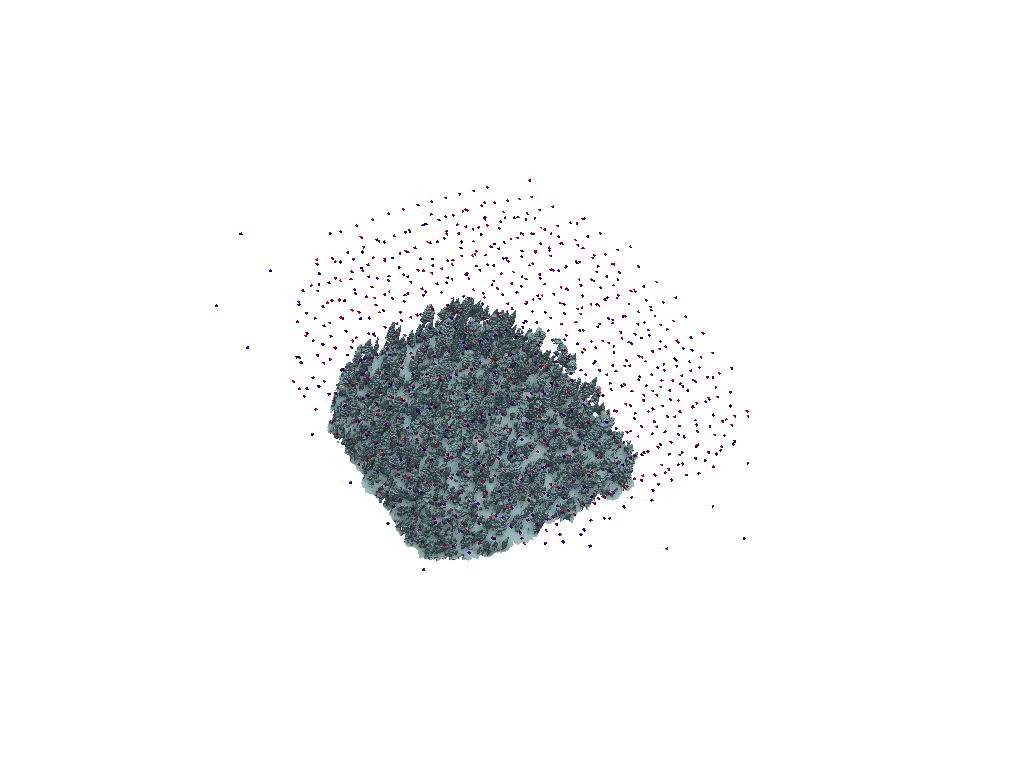

In [5]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

In [6]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(mesh.get_label_names()),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


In [7]:
if USE_CACHED_AGGREGATION:
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

In [8]:
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)

Sampling values from raster /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/inputs/dtm.tif:   0%|          | 1792/705768 [00:00<00:40, 17287.94it/s]

Sampling values from raster /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/inputs/dtm.tif: 100%|██████████| 705768/705768 [00:25<00:00, 27214.01it/s]


# Use the mesh predictions to generate per-polygon labels

In [9]:
# Load the data
polygons = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
polygons = ensure_geometric_CRS(polygons)

# Now create circles around each point
polygons["geometry"] = polygons["geometry"].buffer(3)

predicted_polygon_labels = mesh.label_polygons(
    face_labels=predicted_face_classes,
    polygons=polygons
)

Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 1232100/1232100 [00:19<00:00, 63288.08it/s]

Creating dataframe of faces



Computing ratio of 3d to 2d area: 100%|██████████| 1232100/1232100 [00:11<00:00, 107658.32it/s]
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Starting to subset to ROI
Subset to ROI in 2.57344651222229 seconds
Starting `overlay`
Overlay time with gpd.sjoin: 3.1668429374694824


# Compute prediction accuracy

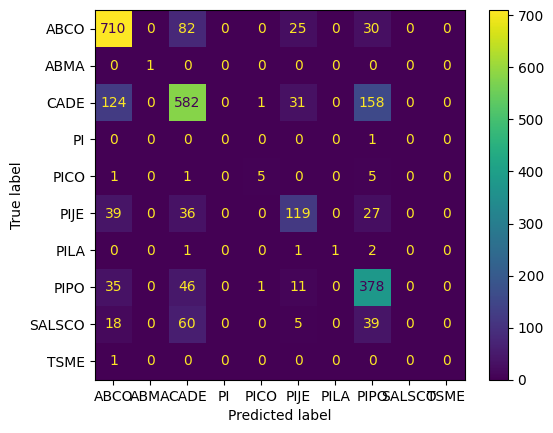

Accuracy was 0.6969344198680636
Comprehensive metrics:
{ 'accuracy': 0.6969344198680636,
  'class_averaged_precision': 0.5410085617551903,
  'class_averaged_recall': 0.44454822036918873,
  'per_class': { 'ABCO': { 'acc': 0.8622429181218471,
                           'num_pred': 928,
                           'num_true': 847,
                           'precision': 0.7650862068965517,
                           'recall': 0.8382526564344747},
                 'ABMA': { 'acc': 1.0,
                           'num_pred': 1,
                           'num_true': 1,
                           'precision': 1.0,
                           'recall': 1.0},
                 'CADE': { 'acc': 0.7904540162980209,
                           'num_pred': 808,
                           'num_true': 896,
                           'precision': 0.7202970297029703,
                           'recall': 0.6495535714285714},
                 'PI': { 'acc': 0.9996119518820333,
                         'num_

/ofo-share/repos-david/geograypher/geograypher/utils/prediction_metrics.py:306: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / num_pred


In [10]:
# Extract the ground truth classes
ground_truth_labeling = polygons[LABEL_COLUMN_NAME]
# Get all the possible classes, in case you wanted to compare across sites where only
# a subset of all classes were present at one
all_classes = list(IDS_TO_LABELS.values())
# Compute the confusion matrix
cf_matrix, _, accuracy = compute_and_show_cf(
    pred_labels=predicted_polygon_labels,
    gt_labels=ground_truth_labeling,
    labels=all_classes
)
print(f"Accuracy was {accuracy}")
# Compute more detailed metrics from the confusion matrix
comprehensive_metrics = compute_comprehensive_metrics(
    cf_matrix=cf_matrix,
    class_names=all_classes
)
# Format and print the dict
pp = pprint.PrettyPrinter(indent=2)
print("Comprehensive metrics:")
print(pp.pprint(comprehensive_metrics))